In [1]:
from src.problems.sudoku import Sudoku
from src.problems.morpian_solitaire import MorpionSolitaire5D

The plan is to test the type of reward distributions that Iterative Sampling, NMCS, NRPA, GNRPA, ... make in the game of morpion solitaire.
After comparing the reward distributions we then attempt to solve some simple morpion solitaire and sudoku games using them as rollouts for
the FlatSolver, MABSolver, and MCTS Solver.

Our goal will then be to test modifications and see if possible improvements can be made. One type of improvement we are keen on making is a 
type of nested search that can support high nesting-level which is computationally intractable at the moment.

In [2]:
morpion_solitaire_5d = MorpionSolitaire5D(20)
#morpion_solitaire_5d.apply_action(morpion_solitaire_5d.get_valid_moves()[0])

In [3]:
import seaborn as sns # type: ignore
from sklearn.neighbors import KernelDensity # type: ignore
from sklearn.neighbors import KernelDensity # type: ignore
from scipy.stats import skew, kurtosis # type: ignore
from matplotlib import pyplot as plt
import numpy as np

def plot_kde(important_list, bandwidth=0.75, kernel='gaussian', 
             title='Kernel Density Estimation', xlabel='Reward', ylabel='Density', color='dodgerblue'):
            """
            Plots the kernel density estimation for a given list of integers.
            
            Parameters:
                important_list (list): List of integer values to perform KDE on.
                bandwidth (float): The bandwidth of the kernel. Default is 0.75.
                kernel (str): The kernel to use for KDE. Default is 'gaussian'.
                            Options include 'gaussian', 'tophat', 'epanechnikov', 
                            'exponential', 'linear', 'cosine'.
                title (str): Title of the plot. Default is 'Kernel Density Estimation'.
                xlabel PUCT(str): Label for the x-axis. Default is 'Value'.
                ylabel (str): Label for the y-axis. Default is 'Density'.svg
                color (str): Color of the KDE plot. Default is 'blue'.
            """
            # Convert the list to a numpy array and reshape for scikit-learn
            data = np.array(important_list).reshape(-1, 1)
            
            # Calculate skewness and kurtosis
            data_skewness = skew(important_list)
            data_kurtosis = kurtosis(important_list)

            # Create and fit the KDE model
            kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(data)

            # Create a range of values for the x-axis
            x_d = np.linspace(min(important_list) - 1, max(important_list) + 1, 1000).reshape(-1, 1)

            # Evaluate the KDE on the range of values
            log_dens = kde.score_samples(x_d)

            # Plot the results
            plt.fill_between(x_d[:, 0], np.exp(log_dens), color=color, alpha=0.5)
            plt.plot(data[:, 0], -0.01 - 0.1 * np.random.rand(len(data)), 'ro', label='Data points')
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            #plt.legend()
            
            # Annotate skewness and kurtosis
            plt.text(x_d[0, 0], np.max(np.exp(log_dens)) * 0.8, f'Skewness: {data_skewness:.2f}', color='black')
            plt.text(x_d[0, 0], np.max(np.exp(log_dens)) * 0.7, f'Kurtosis: {data_kurtosis:.2f}', color='black')

            plt.axvline(np.mean(important_list), color='r', linestyle='dashed', linewidth=1)

            plt.show()

In [4]:
from tqdm import tqdm
import copy

def test_rollout(problem, rollout, budget = 100):
    rewards = np.zeros([budget])

    for rollout_number in tqdm(range(budget)):
        duplicate_problem = copy.deepcopy(problem)
        rewards[rollout_number] = rollout(duplicate_problem)
    
    plot_kde(rewards)


In [5]:
from src.primitives.problem import Problem
import random

def iterative_sampling(problem : Problem):

    while not problem.is_game_finished():
        actions = problem.get_valid_moves()
        problem.apply_action(random.choice(actions))
    
    score = problem.get_score()

    return score

156


100%|██████████| 10000/10000 [02:42<00:00, 61.59it/s]


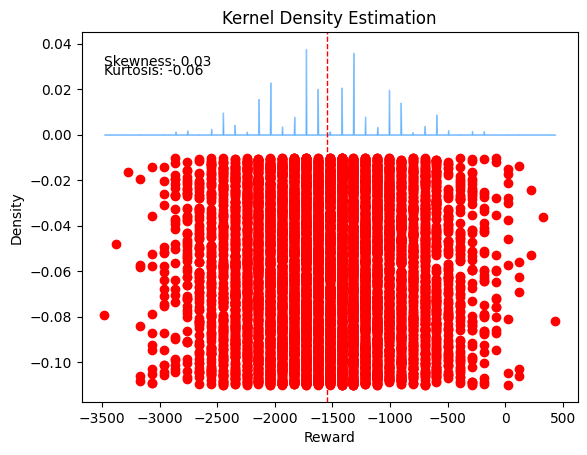

In [19]:
# Making a sudoku problem
sudoku = Sudoku(5)

test_rollout(sudoku, iterative_sampling, budget=10000)

100%|██████████| 1000/1000 [05:16<00:00,  3.16it/s]


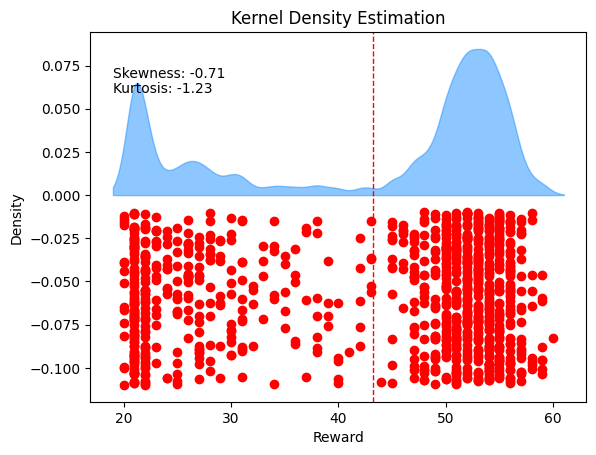

In [21]:
test_rollout(morpion_solitaire_5d, iterative_sampling, budget=1000)

### Selection Policy Based Rollouts

156


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_41794/2941788542.py:43: RuntimeWarning: invalid value encountered in divide
  best_action = actions[np.argmax(total_reward / n_visits)]
100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


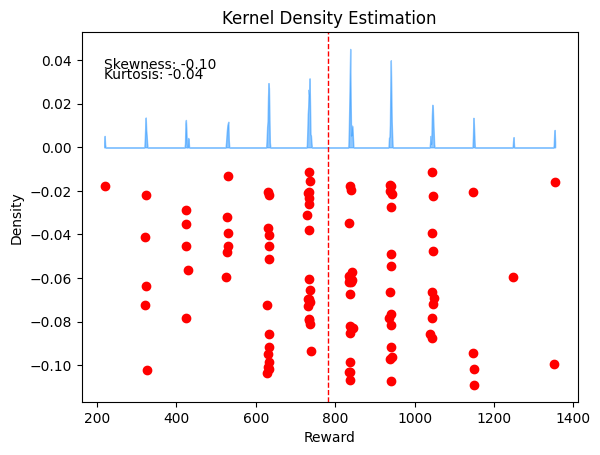

In [11]:
def UCB1Tower(problem, budget_per_action=200):
    depth = 0
    while not problem.is_game_finished():
        #print("Currently at tower depth ", depth)
        depth += 1
        # Get possible moves at this state
        actions = problem.get_valid_moves()

        # Initialize the number of visits and the total reward for each action
        n_visits = np.zeros([len(actions)])
        total_reward = np.zeros([len(actions)])

        # Running the ucb algorithm
        for _ in range(budget_per_action):
            # Select child with maximum UCB value
            ucb_values = np.zeros([len(actions)])
            selected_action = None

            for i, action in enumerate(actions):
                # If the number of visits is 0, select the action
                if n_visits[i] == 0:
                    selected_action = actions[i]
                    break
                else:
                    # Calculate the UCB value
                    ucb_values[i] = total_reward[i] / n_visits[i] + np.sqrt(2 * np.log(sum(n_visits)) / n_visits[i])
            
            if selected_action is None:
                selected_action = actions[np.argmax(ucb_values)]

            # Performing iterative sampling on the selected action
            problem_state = problem.save_state()
            problem.apply_action(selected_action)

            reward = iterative_sampling(problem)
            problem.load_state(problem_state)

            # Updating the total reward and number of visits
            total_reward[actions.index(action)] += reward
            n_visits[actions.index(action)] += 1

        # Selecting the action with the q-value
        best_action = actions[np.argmax(total_reward / n_visits)]
        problem.apply_action(best_action)

    return problem.get_score()

# Making a sudoku problem
sudoku = Sudoku(5)

test_rollout(sudoku, UCB1Tower, budget=100)

In [ ]:
test_rollout(morpion_solitaire_5d, UCB1Tower, budget=100)